In [1]:
%matplotlib inline

#from __future__ import division
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas
import scipy.io as sio
import brian2
import os
import copy
import numba
import nibabel as nib
import networkx as nx

#!pip install git+https://github.com/NeuroanatomyAndConnectivity/surfdist.git
import surfdist
from surfdist import utils, load

import nilearn
from nilearn import plotting

import sys
#sys.version


WARNING    /Users/seanfw/miniconda2/envs/surfgradmodel/lib/python2.7/site-packages/nilearn/__init__.py:73: DeprecationWarning: Python2 support is deprecated and will be removed in the next release. Consider switching to Python 3.6 or 3.7.
  _python_deprecation_warnings()
 [py.warnings]


In [2]:
def current_to_frequency(input_current,population_type,parameters):
    if population_type == 'E':
        return current_to_frequency_E(input_current,parameters['a_E'],parameters['b_E'],parameters['d_E'])
    if population_type == 'I':
        return current_to_frequency_I(input_current,parameters['c_I'],parameters['r0_I'])

def current_to_frequency_E(input_current1,a,b,d):
    return np.divide((a*input_current1 - b),(1 - np.exp(-d*(a*input_current1 - b))))

def current_to_frequency_I(input_current1,c_I,r_0):
    return np.maximum(c_I*input_current1 + r_0,0) 

def NMDA_deriv(S_NMDA_prev,rate_now,parameters):
    return -S_NMDA_prev/parameters['tau_NMDA'] + parameters['gam']*(1 - S_NMDA_prev)*rate_now

def GABA_deriv(S_GABA_prev,rate_now,parameters):
    return -S_GABA_prev/parameters['tau_GABA'] + rate_now 

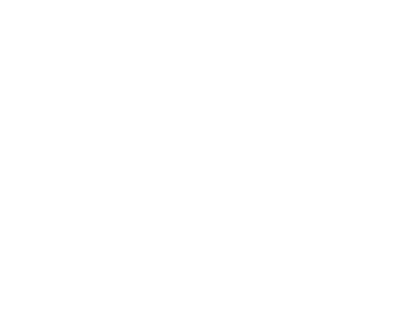

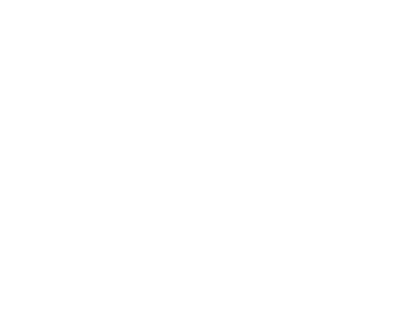

In [12]:
# Mid-distance connectivity

# surf = nib.freesurfer.read_geometry('fsaverage4/lh.pial')
# cortex = np.sort(nib.freesurfer.read_label('fsaverage4/lh.cortex.label'))
surf = nib.freesurfer.read_geometry("/Users/seanfw/Dropbox/papers_in_progress/Margulies_surface_modelling/fsaverage4/lh.pial")
cortex = np.sort(nib.freesurfer.read_label("/Users/seanfw/Dropbox/papers_in_progress/Margulies_surface_modelling/fsaverage4/lh.cortex.label"))
surf_new = surfdist.utils.surf_keep_cortex(surf, cortex)
num_nodes = len(surf_new[0])

g = nx.Graph()
for x,y,z in surf_new[1]:
    g.add_edge(x,y)
    g.add_edge(y,z)

surface_connectivity = np.zeros((num_nodes,num_nodes))
for k in range(len(g.nodes)):
    for i in [j for j in g.neighbors(k)]:
        surface_connectivity[k, i] = 1
    
# f = plotting.plot_surf_roi('/Applications/freesurfer/subjects/fsaverage4/surf/lh.inflated', 
#                             nib.load('conn_data/Glasser_NetworkPartition_v9.fsa4.L.label.gii').darrays[0].data,
#                             hemi='left', cmap='tab20', view='medial')
# f = plotting.plot_surf_roi('/Applications/freesurfer/subjects/fsaverage4/surf/lh.inflated', 
#                             nib.load('conn_data/Glasser_NetworkPartition_v9.fsa4.L.label.gii').darrays[0].data,
#                             hemi='left', cmap='tab20', view='lateral')

f = plotting.plot_surf_roi("/Users/seanfw/Dropbox/papers_in_progress/Margulies_surface_modelling/fsaverage4/lh.inflated", 
                            nib.load("/Users/seanfw/Dropbox/papers_in_progress/Margulies_surface_modelling/conn_data/Glasser_NetworkPartition_v9.fsa3.L.label.gii").darrays[0].data,
                            hemi='left', cmap='tab20', view='medial')
f = plotting.plot_surf_roi("/Users/seanfw/Dropbox/papers_in_progress/Margulies_surface_modelling/fsaverage4/lh.inflated", 
                            nib.load("/Users/seanfw/Dropbox/papers_in_progress/Margulies_surface_modelling/conn_data/Glasser_NetworkPartition_v9.fsa3.L.label.gii").darrays[0].data,
                            hemi='left', cmap='tab20', view='lateral')


In [16]:
# White matter tract connectivity

tract_connectivity = np.zeros((num_nodes,num_nodes))

# load Murray data from Balsa:
conn_mat = np.asarray(nib.load('conn_data/average_sc.pconn.nii').get_data())

# load labels:
# labels = np.concatenate((nib.load('conn_data/Glasser_NetworkPartition_v9.fsa4.L.label.gii').darrays[0].data, 
#                          nib.load('conn_data/Glasser_NetworkPartition_v9.fsa4.R.label.gii').darrays[0].data))

# load labels for only left hemisphere:
labels = nib.load('conn_data/Glasser_NetworkPartition_v9.fsa4.L.label.gii').darrays[0].data[cortex]

# normalize so that rows sum to 1:
conn_mat_rowtotal = np.sum(conn_mat,axis=1)
conn_rowtotal_mat = np.matlib.repmat(conn_mat_rowtotal, len(conn_mat), 1).T
conn_mat_norm = conn_mat/conn_rowtotal_mat

# resample to surface:
tract_connectivity = conn_mat_norm[labels-1,:][:,labels-1]

# binarize:
# tract_connectivity = (tract_connectivity > 0.001).astype(np.int_)


# viz:
node = 90
f = plotting.plot_surf_stat_map('fsaverage4/lh.inflated', 
                                surfdist.utils.recort(tract_connectivity[node,:], surf, cortex), 
                                hemi='left', view='medial')
f = plotting.plot_surf_stat_map('fsaverage4/lh.inflated', 
                                surfdist.utils.recort(tract_connectivity[node,:], surf, cortex), 
                                hemi='left', view='lateral')

IndexError: index 642 is out of bounds for axis 0 with size 642

In [5]:
#g_E_self, g_IE, g_I_self, g_EI
g_E_self=0.39
g_IE=0.23
g_I_self=-0.05
g_EI=-0.4

parameters = {}

parameters.update({ # Time constants
                    'tau_NMDA': 0.06   * brian2.second,    # s 
                    'tau_AMPA': 0.002   * brian2.second,    # s 
                    'tau_GABA': 0.005  * brian2.second,    # s 
                    'tau_rates': 0.002 * brian2.second,    # s 

                    # f-I curve parameters - E populations
                    'a_E': 270.  * brian2.Hz/brian2.nA / 2.,  # Hz/nA
                    'b_E': 108.  * brian2.Hz / 2.,            # Hz
                    'd_E': 0.154 * brian2.second * 2.,        # s
                    'gam': 0.641 * 2.,                         # unitless

                    # f-I curve parameters - I populations
                    'c_I': 330 * brian2.Hz/brian2.nA,                 # Hz/nA
                    'r0_I': -95 * brian2.Hz,

                    # Strength of connections from E cells
                    'g_E_self': g_E_self * brian2.nA ,        # nA - from E to E
                    'g_IE': g_IE * brian2.nA ,            # nA - from E to I

                    # Strength of connections from I cells
                    'g_I_self': g_I_self  * brian2.nA,     # nA  - from I to I
                    'g_EI': g_EI * brian2.nA,     # nA  - from I to E

                    # Strength of mid-range connections (along surface)
                    'g_E_midRange': 0.09 * brian2.nA,
                    'g_E_longRange': 0.2 * brian2.nA,
    
    
                    # Background inputs
                    'I0_E': 0.20     * brian2.nA,           # nA - background onto E population
                    'I0_I': 0.18      * brian2.nA,         # nA - background onto I population

                    # Noise std dev
                    'std_noise': 0.01 * brian2.nA,         # nA  - standard deviation of noise input  

                    # initial values
                    'r0_E': 5 * brian2.Hz,

                    # stimulus strength
                    'stim_strength': 0.2 * brian2.nA
                        })      

######## LOCAL CONNECTIVITY MATRIX ########
J =  np.array([
                [parameters['g_E_self'] , parameters['g_EI']],
                [parameters['g_IE'] , parameters['g_I_self']]

              ]) * brian2.amp

pops = ['E','I']
pops_column_list  = ['from '+ mystring for mystring in pops]
pops_row_list  = ['to '+ mystring for mystring in pops]

J_NMDA = J*((J>0).astype(np.int))
J_GABA = J*((J<0).astype(np.int))

df_J = pandas.DataFrame(J, columns=pops_column_list, index=pops_row_list)

num_pops  = J.shape[0]

# Choose initial values for rates and synapse variables
R0 = np.ones((num_nodes, num_pops))
R0 = R0 * parameters['r0_E']
S_NMDA0 = np.ones((num_nodes,num_pops)) * 0.1
S_GABA0 = np.zeros((num_nodes,num_pops))

#### Set up simulation details
# Set up simulation parameters
dt=0.5 * brian2.ms  # timestep 
trial_length=5000 * brian2.ms # trial length (s)
num_iterations = int(trial_length/dt)
time = np.arange(0, trial_length, dt)


# Preassign rate and synapse matrices
R           = np.zeros((num_iterations,num_nodes,num_pops)) * brian2.Hz
R[0,:,:]      = R0
S_NMDA      = np.zeros((num_iterations,num_nodes,num_pops))
S_NMDA[0,:,:] = S_NMDA0
S_GABA      = np.zeros((num_iterations,num_nodes,num_pops))
S_GABA[0,:,:] = S_GABA0

# # Preassign external inputs
I_ext        = np.zeros((num_iterations,num_nodes,num_pops)) * brian2.amp
stim_on      = 1 * brian2.second #s
stim_off     = 1.5 * brian2.second #s


################################
##### ROI for Stimulation: #####
################################

# Let's apply external stimulation to V1 populations E1 & E2

V1 = surfdist.load.load_freesurfer_label('fsaverage4/lh.aparc.a2009s.annot', 'S_calcarine')
V1_index = surfdist.utils.translate_src(V1, cortex)

I_ext[int(stim_on/dt):int(stim_off/dt),V1_index,0] = parameters['stim_strength']

# Create matrices in which we can store the currents
I_longRange_NMDA = np.zeros((num_iterations,num_nodes,num_pops)) * brian2.pA
I_midRange_NMDA = np.zeros((num_iterations,num_nodes,num_pops)) * brian2.pA
I_local_NMDA =  np.zeros((num_iterations,num_nodes,num_pops)) * brian2.pA
I_local_GABA =  np.zeros((num_iterations,num_nodes,num_pops)) * brian2.pA
I_total      =  np.zeros((num_iterations,num_nodes,num_pops)) * brian2.pA
I_noise      =  np.zeros((num_nodes,num_pops)) * brian2.pA

# # Define background inputs
I_0 = np.zeros((num_nodes, num_pops)) * brian2.pA
I_0[:,pops.index('E')] = parameters['I0_E']
I_0[:,pops.index('I')] = parameters['I0_I']

# Let's set up the noise. We will model the noise as an Ornstein-Uhlenbeck process.
# https://en.wikipedia.org/wiki/Ornstein–Uhlenbeck_process

# Gaussian noise. mean 0, std 1. Dims: timesteps, local populations, areas
eta = np.random.normal(loc=0.0, scale=1.0, size=(num_iterations,num_nodes,num_pops))

# prepare the right hand side of the above equation
noise_rhs = eta*((np.sqrt(parameters['tau_AMPA']*np.power(parameters['std_noise'],2))*np.sqrt(dt))/parameters['tau_AMPA'])

#print(I_0)

In [2]:
# DELAYS

# Along the surface, all nodes area neighbours. They are ~1mm apart. 
# Activity propagates along the surface at about 0.33 m/s = 330mm/s = 0.33mm/ms = 0.165 mm/dt
# Therefore there is a delay of about 6 timesteps for activity propagation along the surface
# (Girard, Hupé & Bullier, J Neurophysiol, 2001)

# Along the white matter, there are connections of different lengths.

# euclidean distance between nodes:

from scipy.spatial import distance_matrix

distances = distance_matrix(surf_new[0], surf_new[0]) # this is distance in vertices - let's assume = 1mm

tract_delays = numpy.round(distances/1.75, decimals=0) # in units of timesteps

# In the white matter, activity propagates at about 3.5m/s, but it might propagate more quickly for 
# longer/larger tracts. 
# 3.5 m/s = 3.5mm/ms = 1.75mm/dt
# (Girard, Hupé & Bullier, J Neurophysiol, 2001)

max_delay = np.max(tract_delays) # in timesteps

# initialise the matrix which stores the delayed 
# synaptic drive variables (transmitted via white matter tracts)
S_tract_delay = np.zeros((num_nodes,num_nodes)) 




NameError: name 'surf_new' is not defined

In [8]:
#### Run model with LONG DISTANCE:
for i_t in range(1,num_iterations):

    # update noise - dims = num local pops x num areas
    I_noise = I_noise + -I_noise*(dt/parameters['tau_AMPA']) + noise_rhs[i_t-1,:,:]

    # long range NMDA (along white matter tracts) with variable delays
    I_longRange_NMDA[i_t-1,:,:] = parameters['g_E_longRange'] * np.sum(tract_connectivity*S_tract_delay,axis=1)
    
    # mid range NMDA (along surface), with a 6 timestep delay
    I_midRange_NMDA[i_t-1,:,:] = parameters['g_E_midRange'] * surface_connectivity.dot(S_NMDA[i_t-7,:,:])
    
    # local NMDA
    I_local_NMDA[i_t-1,:,:] = J_NMDA.dot(S_NMDA[i_t-1,:,:].T).T
    
    # sum up all the local GABA current onto E and I cell somas
    I_local_GABA[i_t-1,:,:] = J_GABA.dot(S_GABA[i_t-1,:,:].T).T

    # Define total input current as sum of local NMDA & GABA inputs, with background, external currents & noise & longRange
    I_total[i_t-1,:,:] = I_local_NMDA[i_t-1,:,:] +  I_local_GABA[i_t-1,:,:] + I_0 + I_ext[i_t-1,:,:] + I_noise + I_midRange_NMDA[i_t-1,:,:] + I_longRange_NMDA[i_t-1,:,:]

    # Update the firing rates of the excitatory population
    R[i_t,:,0] = R[i_t-1,:,0] + dt*current_to_frequency(I_total[i_t-1,:,0],'E',parameters)/parameters['tau_rates']-dt*R[i_t-1,:,0]/parameters['tau_rates']

    # Update the firing rates of the inhibitory population. 
    R[i_t,:,1] = R[i_t-1,:,1] + dt*current_to_frequency(I_total[i_t-1,:,1],'I',parameters)/parameters['tau_rates']-dt*R[i_t-1,:,1]/parameters['tau_rates']

    # Update the NMDA synapses
    S_NMDA[i_t,:,0] = S_NMDA[i_t-1,:,0] + dt*NMDA_deriv(S_NMDA[i_t-1,:,0],R[i_t,:,0],parameters)

    S_tract_delay = S_NMDA[i_t-tract_delays,range(num_vertices),0]
    
    # Update the GABA synapses
    S_GABA[i_t,:,1] = S_GABA[i_t-1,:,1] + dt*GABA_deriv(S_GABA[i_t-1,:,1],R[i_t,:,1],parameters)



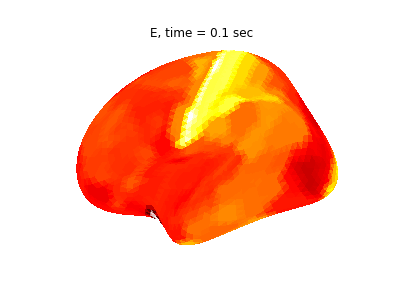

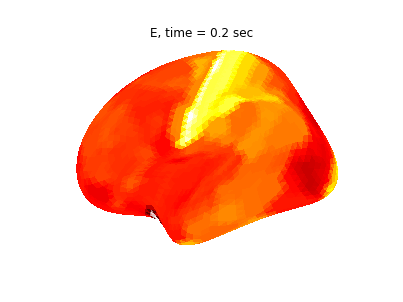

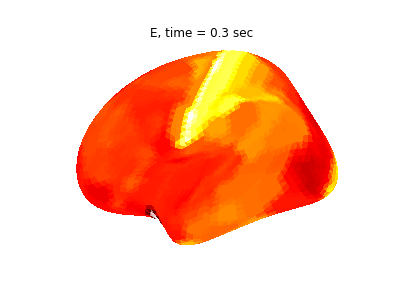

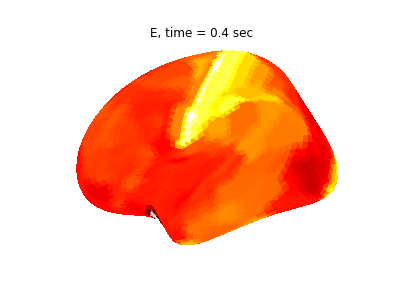

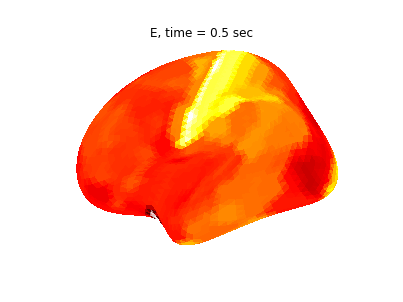

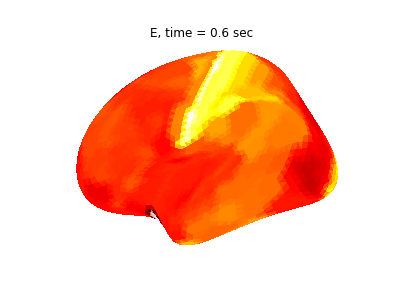

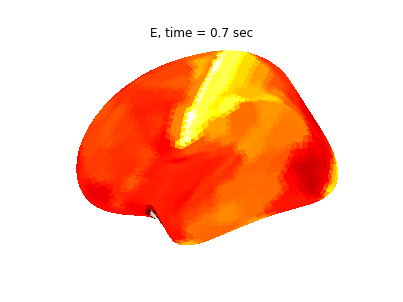

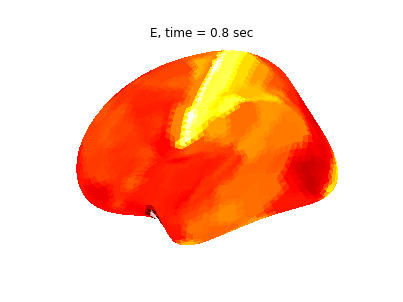

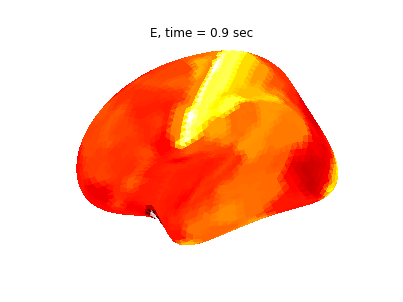

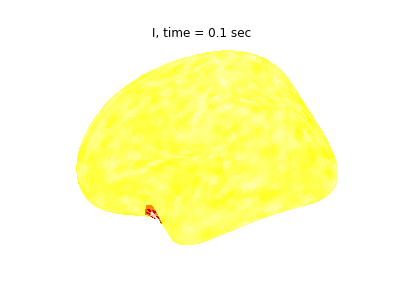

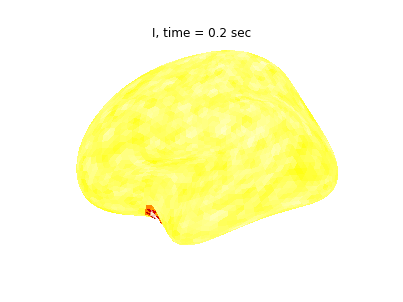

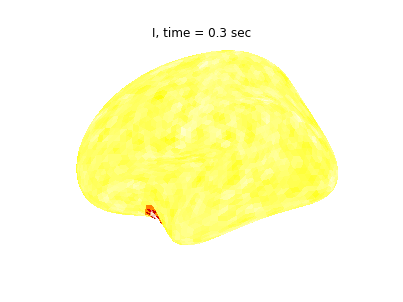

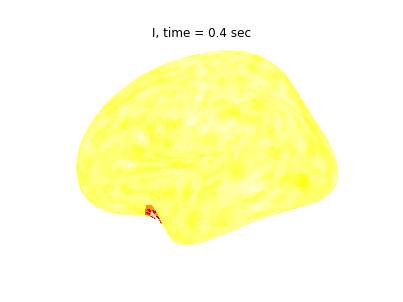

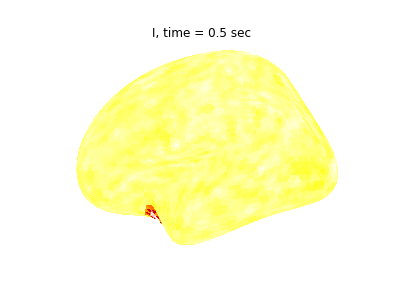

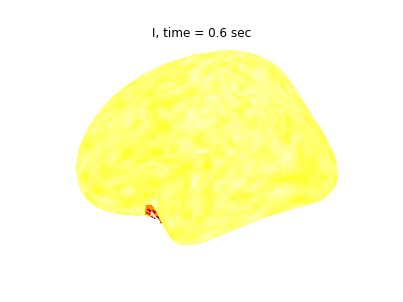

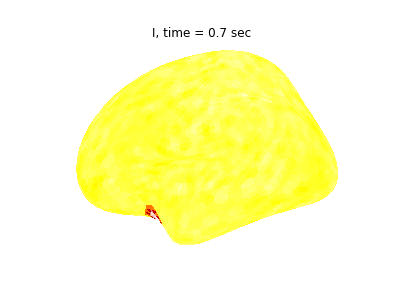

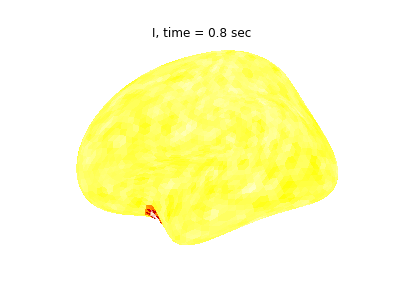

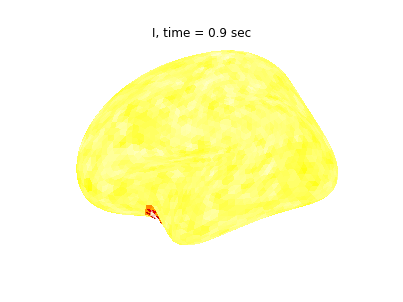

In [9]:
# plot E:
for i in range(1,10):
    start_time = np.float(i)/10.
    plotting.plot_surf_stat_map('fsaverage4/lh.inflated', 
                                surfdist.utils.recort(R[np.arange(int(start_time/dt),int(start_time/dt)+1,1),:,0], 
                                                  surf, cortex),
                                title=('E, time = %.1f sec' % start_time),
                                colorbar = False
                               )
# plot E:
for i in range(1,10):
    start_time = np.float(i)/10.
    plotting.plot_surf_stat_map('fsaverage4/lh.inflated', 
                                surfdist.utils.recort(R[np.arange(int(start_time/dt),int(start_time/dt)+1,1),:,1], 
                                                  surf, cortex),
                                title=('I, time = %.1f sec' % start_time),
                                colorbar = False
                               )


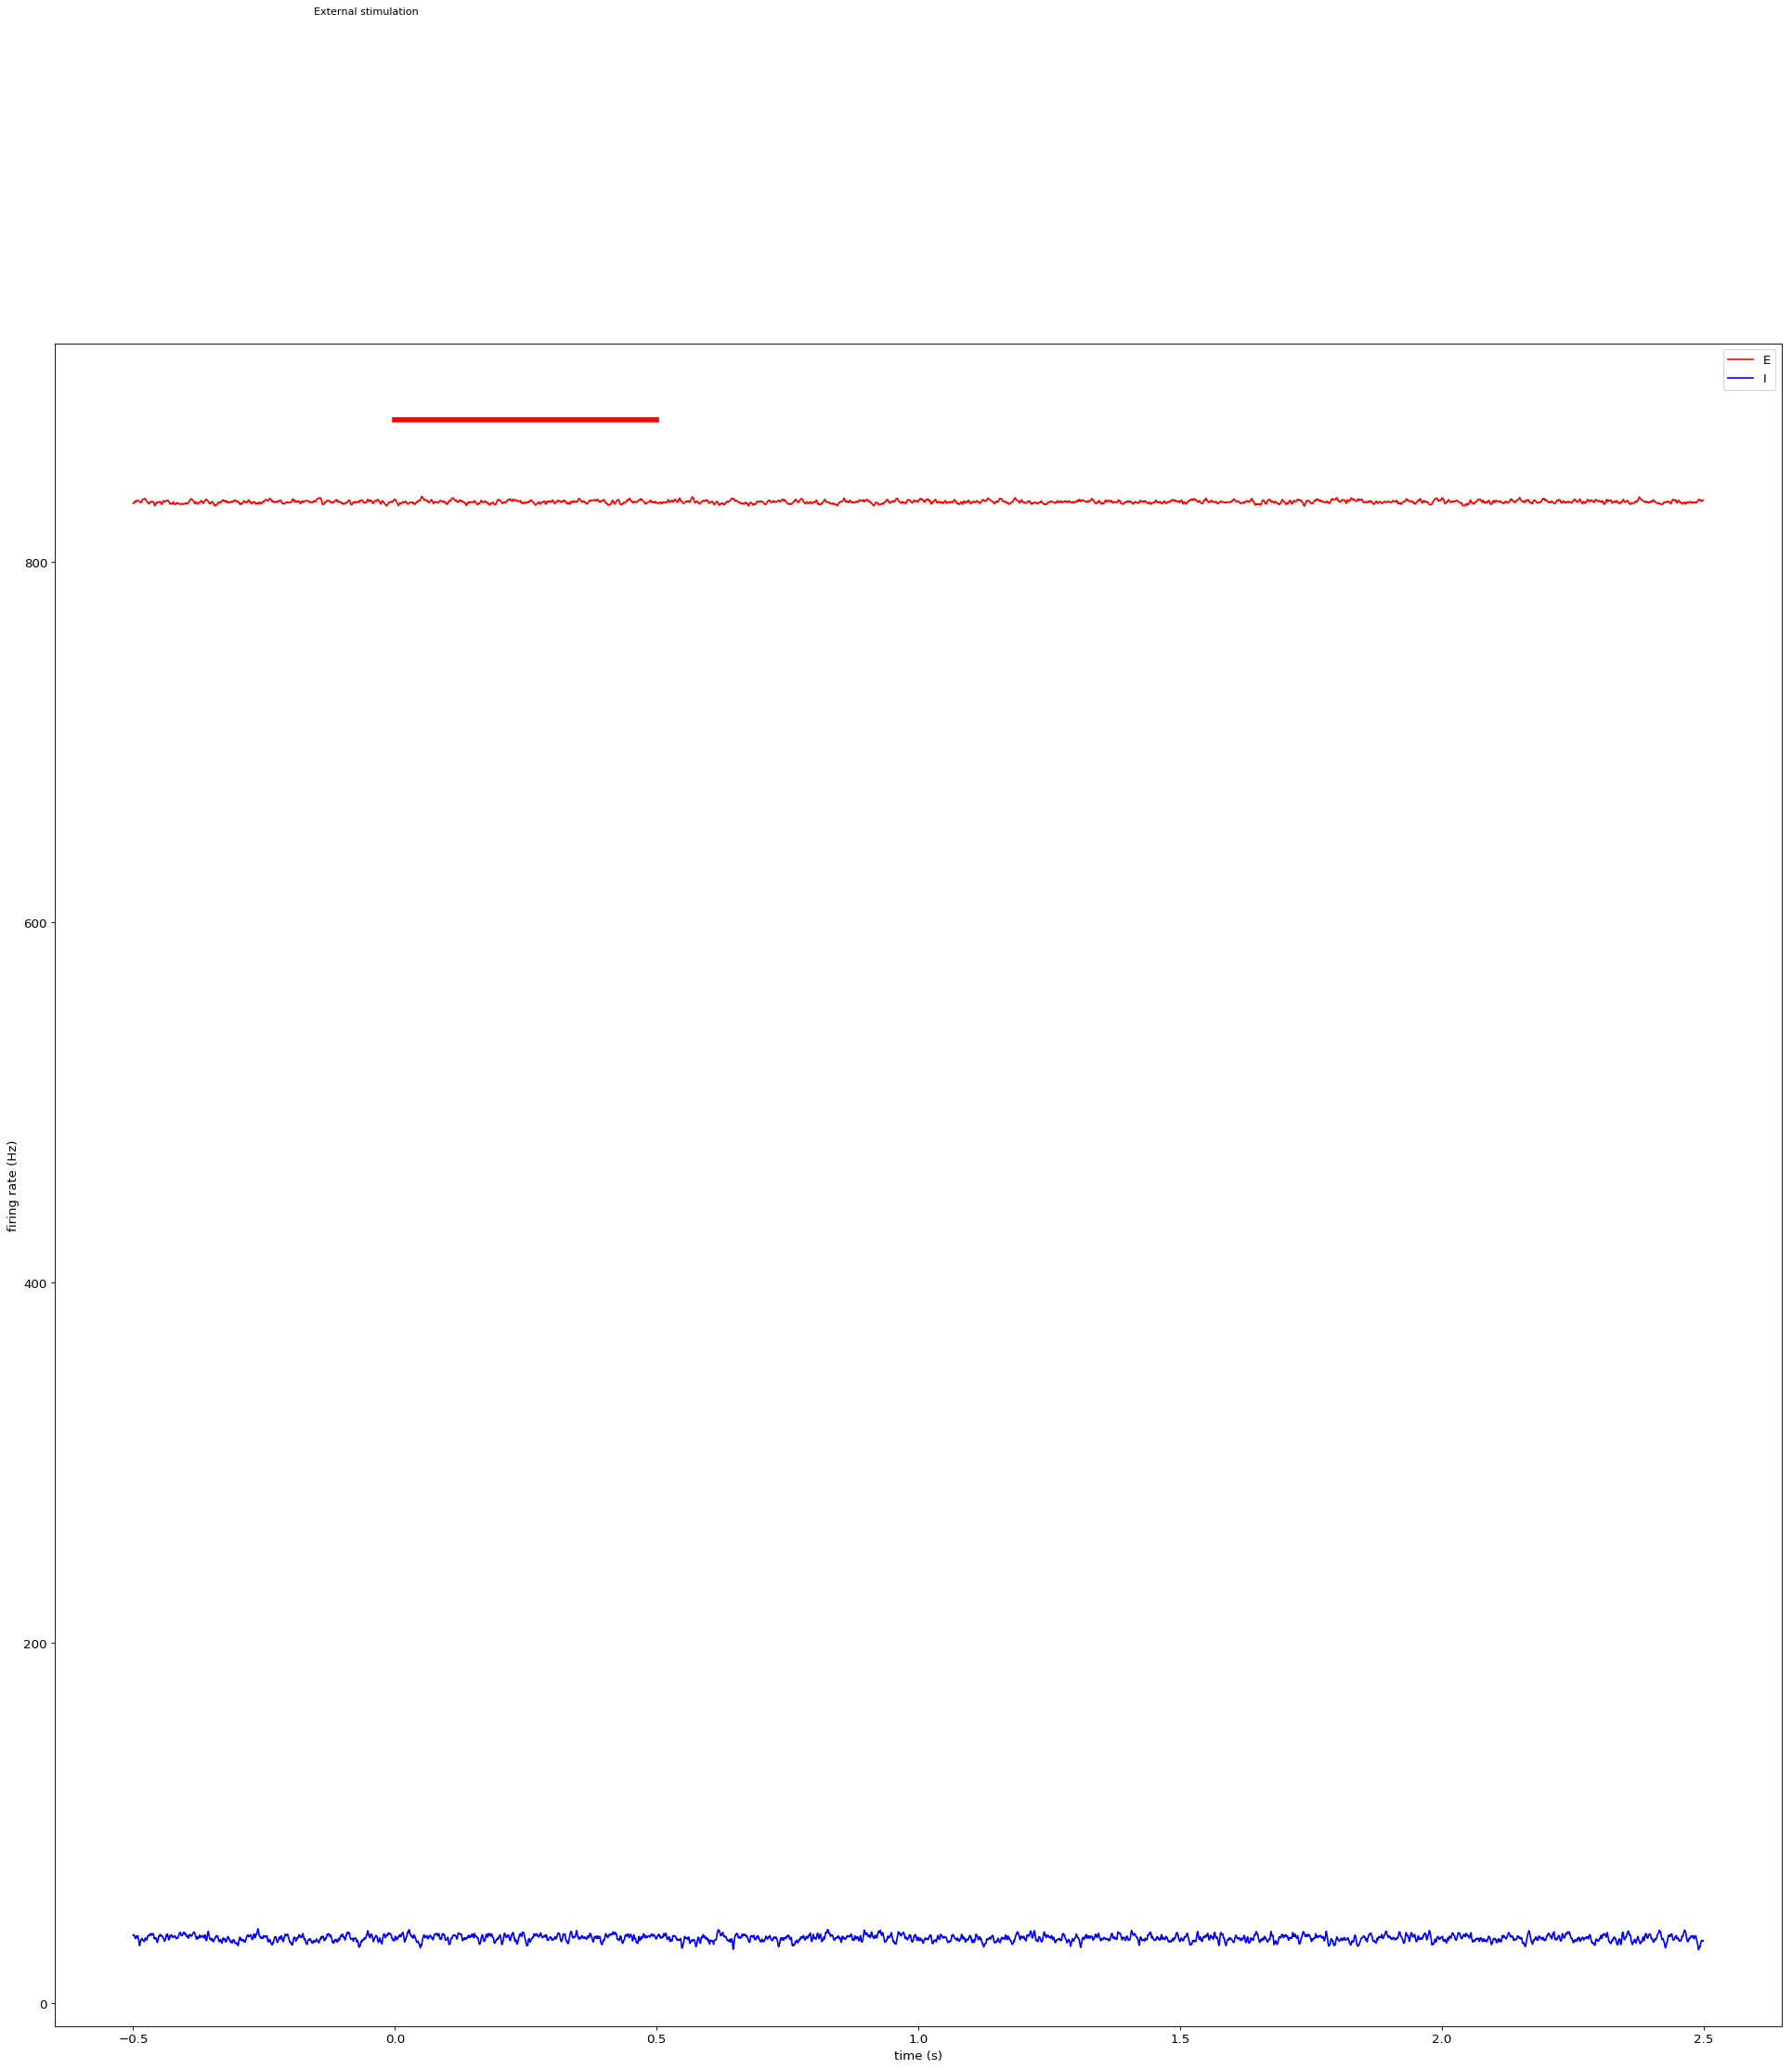

In [10]:
# To check response to stimulus

fig = plt.figure(figsize=(30,30), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
start_time = 0.5 #seconds
end_time = 3.5 #seconds
i = V1[0][10]
#ax = plt.subplot(10, 10, i)    

# Plot E population rates
plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),i-1,0],color='r')
# Plot I population rates
plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),i-1,1],color='b')

# Plot the stimulation time
plt.plot([stim_on-1*brian2.second,stim_off-1*brian2.second],[np.max(R+0.05*np.max(R)),np.max(R+0.05*np.max(R))],color='r',linewidth=5.0)

# place text above the stimulation line
axes = plt.gca()
axes.text(0.15, 1.2,'External stimulation', transform=axes.transAxes, fontsize=10, verticalalignment='top')

plt.legend(['E','I'])
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
# plt.ylim(0, 80) 

plt.show()

In [ ]:
'''
fig=plt.figure(figsize=(30,30), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 12})
start_time = 0.5 #seconds
end_time = 3.5 #seconds

for i in range(1,num_nodes+1):
    ax = plt.subplot(np.sqrt(num_nodes), np.sqrt(num_nodes), i)    

    # Plot E population rates
    plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),i-1,0],color='r')
    # Plot I population rates
    plt.plot(np.arange((start_time-1)*brian2.second,(end_time-1)*brian2.second,dt),R[np.arange(int(start_time/dt),int(end_time/dt),1),i-1,1],color='b')

    # Plot the stimulation time
    plt.plot([stim_on-1*brian2.second,stim_off-1*brian2.second],[np.max(R+0.05*np.max(R)),np.max(R+0.05*np.max(R))],color='r',linewidth=5.0)

    # place text above the stimulation line
    axes = plt.gca()
    axes.text(0.15, 1.2,'External stimulation', transform=axes.transAxes, fontsize=10, verticalalignment='top')

    plt.legend(['E','I'])
    plt.xlabel('time (s)')
    plt.ylabel('firing rate (Hz)')
    # plt.ylim(0, 80) 

plt.show()
'''

In [ ]:
# Notes (4.4.19):
# 1. increase inhibition firing rate compared to excitatory populations
# 2. AMPA receptors? 
# 3. Delays?
# 4. Mechanism such that firing dies off? Oscillating?
# 5. Bring in heterogeneity
# 6. real structural basis for connectivity data

In [ ]:
# Next steps (24.4.19):
# 1) Apply the delay matrix to long-range connections.
# 2) Incorporate Daniel & Sean’s changes
# 3) Run mid-range (surface propagation) code on entire cortical surface
# 4) Write results back to surface
# 5) Take John Murray’s white-matter connectivity matrix from Balsa and take it to the vertex level
# 6) Calculate Euclidean distances between vertices
# 7) Run long-range (surface and white-matter propagation with delays) code on entire cortical surface